In [64]:
import influxdb_client
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
import os

def find_daytime(arr):
    #find start of day
    for i, element in enumerate(arr):
        if element > 0.1:
            start = i
            break
    #find end of day
    for i, element in enumerate(arr[::-1]):
        if element >= 0.1:
            end = len(arr)-i
            break
    return start, end

def get_data(nodeId, start, stop):
  #set influxDB access
  token = "tpvr6ve_kbZqMH1YypOEY17Bkz6dF7ccxd_pycGUmOsPowCMHTQvNzPKBhdoPFKddZY4yJgEdt49Bu4Lo-5NmA=="
  org = "home"
  url = "http://192.168.8.15:8086"
  client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)
  query_api = client.query_api()

  #set timezone
  local_tz = pytz.timezone('Europe/Berlin')
  start = local_tz.localize(start)
  stop = local_tz.localize(stop)

  #create queries
  labels = {
      "drain":  {"query": '|> filter(fn: (r) => r["_measurement"] == "nodeID")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "4")'},
      "drip":   {"query": '|> filter(fn: (r) => r["_measurement"] == "nodeID")|> filter(fn: (r) => r["_field"] == "volume")|> filter(fn: (r) => r["channel"] == "3")'},
      "humi":   {"query": '|> filter(fn: (r) => r["_measurement"] == "nodeID")|> filter(fn: (r) => r["_field"] == "humidity")'},
      "temp":   {"query": '|> filter(fn: (r) => r["_measurement"] == "nodeID")|> filter(fn: (r) => r["_field"] == "temperature")'},
      "light":  {"query": '|> filter(fn: (r) => r["_measurement"] == "2CF7F1C0449000CD")|> filter(fn: (r) => r["_field"] == "light_intensity")'},
  }

  for label in labels:
    genericFluxQuery = 'from(bucket: "SensorNodes")|> range(start: startTime, stop: stopTime)' + labels[label]["query"]
    genericFluxQuery = genericFluxQuery.replace("startTime",start.isoformat())  #replace start time
    genericFluxQuery = genericFluxQuery.replace("stopTime",stop.isoformat())    #replace stop time
    genericFluxQuery = genericFluxQuery.replace("nodeID", nodeId)               #replace nodID

    tables = query_api.query(genericFluxQuery, org=org)

    x_time = []
    y_value = []

    for table in tables:
      for record in table.records:
        time = record["_time"] - start
        x_time.append(time.total_seconds())
        y_value.append(record["_value"])

    #interpolate if it not fits the drain measurment
    if label != "drain":
      labels[label]["value"] = np.interp(labels["drain"]["time"],x_time,y_value)
      labels[label]["time"] = labels["drain"]["time"]
    else:
      labels[label]["value"] = y_value
      labels[label]["time"] = x_time

  #cut labeled data to daytime
  start, stop = find_daytime(labels["light"]["value"])
  for label in labels:
    labels[label]["value"] = labels[label]["value"][start:stop]
    labels[label]["time"] = labels[label]["time"][start:stop]
  return labels

#month day tuples
dataD0 = [(5,16),(5,17),(5,18),(5,19),(5,20),(5,21),(5,22),(5,23),(5,24),(5,25),(5,26),(5,27),(5,28),(5,29),(5,30),(5,31),
          (6,2),(6,3),(6,14),(6,15),(6,16),(6,17),(6,18),(6,19),(6,20),(6,21),(6,22),(6,23),(6,24),(6,25),(6,26),(6,27),
          (7,6),(7,7),(7,8),(7,9),(7,10),(7,11),(7,15),
          (8,19),(8,20),(8,21),(8,22),(8,23),(8,24),(8,25),(8,26),(8,27),(8,28),(8,29),(8,30),(8,31),
          (9,1),(9,11),(9,12),(9,13),(9,14)]
dataD0problem = [(6,4),(6,5),(6,6),(6,8),(6,28),(6,29),(6,30),(7,1),(7,2),(7,3),(7,4),(7,5),(7,12),(7,13),(7,14),(7,16),(7,24),
                 (7,25),(7,26),(7,27),(7,28),(7,29),(9,2),(9,3),(9,4),(9,5),(9,6),(9,8),(9,9),(9,10),(9,15),(9,16),(9,17),(9,18)]
dataD2 = [(5,16),(5,17),(5,18),(5,19),(5,20),(5,21),(5,22),(5,23),(5,24),(5,25),(5,28),(6,7),(6,8),(7,8)]
dataD2problem = [(5,26),(5,27),(5,29),(5,30),(5,31),(6,2),(6,3),(6,4),(6,5),(6,6)]

#wechseln von Drip und Drain
dataD1 = [(6,23),(6,24),(6,25),(6,26),(7,6),(7,7),(7,9),(7,10),(7,11),(7,15),(7,16),(7,25),(7,26),(7,27),(7,28),(8,19)]
dataD1problem = [(6,27),(6,28),(6,29),(8,20),(8,21),(8,22),(8,23),(9,8),(9,9),(9,10),(9,11),(9,12),(9,13),(9,14),(9,15)]

#create data tuples
data = [("70B3D57ED005C6D0", dataD0, dataD0problem), ("70B3D57ED005C6D1", dataD1, dataD1problem), ("70B3D57ED005C6D2", dataD2, dataD2problem)]

def lux_to_megajoule(time_array, lux_array):
    if len(time_array) != len(lux_array):
        raise ValueError("Die Arrays müssen die gleiche Länge haben.")

    # Berechne die Zeitdifferenzen
    time_diff = np.diff(time_array)
    # Berechne den Durchschnitts-Lux-Wert während jeder Zeitspanne
    avg_lux_array = (lux_array[:-1] + lux_array[1:]) / 2.0
    Ws_per_m2 = (avg_lux_array/125)*time_diff * 1e-6 #to MegaJoule #https://www.landwirtschaftskammer.de/gartenbau/beratung/technik/artikel/lichtwerte-umrechnen.htm
    return np.insert(Ws_per_m2,0,Ws_per_m2[0]) #Duplicate first Element in array to get same size array as input

def day_number_in_year(month, day):
    # Create a datetime object with the given month and day
    date_object = datetime(year=2023, month=month, day=day)
    # Get the ordinal day (day of the year)
    return date_object.timetuple().tm_yday


In [65]:
from __future__ import annotations
import numpy as np
from typing import Sequence, Dict, Any, Optional

def lux_timeseries_to_energy(
    seconds: Sequence[float],
    lux: Sequence[float],
    eta_lm_per_W: float = 125.0,
    clip_negative: bool = True,
    return_series: bool = True
) -> Dict[str, Any]:
    """
    Integriert eine Lux-Zeitreihe zu flächenbezogener Energie (MJ/m²) und kWh/m².

    Physikalischer Zusammenhang:
      E_e(t) [W/m²] = E_v(t) [lx] / η [lm/W]
      H     [J/m²] = ∫ E_e(t) dt
      MJ/m²        = H / 1e6
      kWh/m²       = MJ/m² / 3.6

    Parameter
    ---------
    seconds : Sequenz[float]
        Zeitstempel in Sekunden (beliebige Startzeit, Hauptsache monoton).
    lux : Sequenz[float]
        Lux-Werte zum jeweiligen Zeitpunkt (lm/m²).
    eta_lm_per_W : float, default 120.0
        Luminous efficacy of radiation (lm/W). Für Sonnenlicht ≈116–122; Default 125.
        ->  E_e = lux / eta_lm_per_W
    clip_negative : bool, default True
        Negative Lux-Werte auf 0 klemmen (sicherheitsmaßnahme gegen Ausreißer).
    return_series : bool, default True
        Gibt zusätzlich die Zeitreihe der momentanen Bestrahlungsstärke und die
        kumulative Energie zurück.

    Rückgabe
    --------
    dict mit Feldern:
        - energy_MJ_m2   : float    Gesamte Energie [MJ/m²]
        - energy_kWh_m2  : float    Gesamte Energie [kWh/m²]
        - time_s         : np.ndarray (optional)
        - irradiance_W_m2: np.ndarray (optional) momentane Bestrahlungsstärke
        - cumulative_MJ_m2: np.ndarray (optional) kumulative Energie
    """
    seconds = np.asarray(seconds, dtype=float)
    lux = np.asarray(lux, dtype=float)

    if seconds.size != lux.size:
        raise ValueError("seconds und lux müssen gleich lang sein.")
    if seconds.size < 2:
        raise ValueError("Mindestens zwei Messpunkte erforderlich.")
    if eta_lm_per_W <= 0:
        raise ValueError("eta_lm_per_W muss > 0 sein.")

    # 1) NaNs entfernen
    m = np.isfinite(seconds) & np.isfinite(lux)
    seconds, lux = seconds[m], lux[m]
    if seconds.size < 2:
        raise ValueError("Zu wenige gültige Werte nach Entfernung von NaN/Inf.")

    # 2) Sortieren + Duplikate im Zeitstempel mitteln
    idx = np.argsort(seconds)
    seconds, lux = seconds[idx], lux[idx]
    unique_t, inv = np.unique(seconds, return_inverse=True)
    if unique_t.size != seconds.size:
        # Lux-Werte je identischem Zeitstempel mitteln
        lux_avg = np.zeros_like(unique_t)
        counts = np.bincount(inv)
        sums = np.bincount(inv, weights=lux)
        lux = sums / counts
        seconds = unique_t

    # 3) Negatives clippen (optional)
    if clip_negative:
        lux = np.maximum(lux, 0.0)

    # 4) Lux -> W/m² mit luminous efficacy of radiation η
    #     (Lux ist lm/m²; Division durch lm/W ergibt W/m²)
    irradiance_W_m2 = lux / eta_lm_per_W

    # 5) Integration (Trapezregel) -> J/m²
    #    np.trapz integriert y über x (hier: W/m² über Sekunden = J/m²)
    energy_J_m2 = np.trapz(irradiance_W_m2, seconds)
    energy_MJ_m2 = energy_J_m2 / 1e6
    energy_kWh_m2 = energy_MJ_m2 / 3.6

    result: Dict[str, Any] = {
        "energy_MJ_m2": float(energy_MJ_m2),
        "energy_kWh_m2": float(energy_kWh_m2),
    }

    if return_series:
        # Kumulative Energie in MJ/m² (per Trapezsumme)
        dt = np.diff(seconds)
        mid = 0.5 * (irradiance_W_m2[:-1] + irradiance_W_m2[1:])
        cum_J_m2 = np.concatenate(([0.0], np.cumsum(mid * dt)))
        result.update({
            "time_s": seconds,
            "irradiance_W_m2": irradiance_W_m2,
            "cumulative_MJ_m2": cum_J_m2 / 1e6,
        })

    return result

C:\Users\NilsWindows\AppData\Local\Temp\ipykernel_19176\3901299273.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy_J_m2 = np.trapz(irradiance_W_m2, seconds)


New Method Total Energy (MJ/m²): 25.870356012933822
Old Method Total Energy (MJ/m²): 25.87035707605882


Text(0, 0.5, 'Cumulative Energy (MJ/m²)')

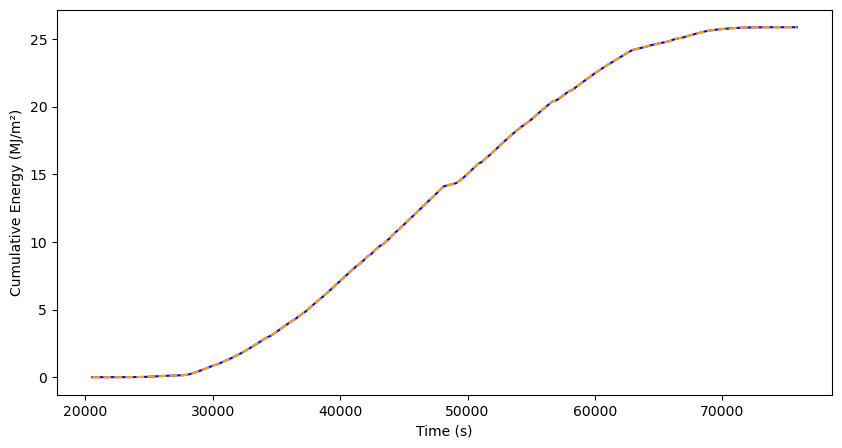

In [66]:
testMJm2Data = get_data("70B3D57ED005C6D0", datetime(2023, 8, 23), datetime(2023, 8, 24))
newLux = lux_timeseries_to_energy(testMJm2Data["light"]["time"], testMJm2Data["light"]["value"])
oldLux = lux_to_megajoule(testMJm2Data["light"]["time"], testMJm2Data["light"]["value"])

plt.figure(figsize=(10, 5))
plt.plot(newLux["time_s"], newLux["cumulative_MJ_m2"], label="New Method (lux_timeseries_to_energy)", color='blue')
plt.plot(testMJm2Data["light"]["time"], np.cumsum(oldLux), label="Old Method (lux_to_megajoule)", color='orange', linestyle='--')
plt.xlabel("Time (s)")

#vergleiche beide array old new
testData = get_data("70B3D57ED005C6D0", datetime(2023, 8, 23), datetime(2023, 8, 24))
newLux = lux_timeseries_to_energy(testData["light"]["time"], testData["light"]["value"])
oldLux = lux_to_megajoule(testData["light"]["time"], testData["light"]["value"])
print(f"New Method Total Energy (MJ/m²): {newLux['energy_MJ_m2']}")
print(f"Old Method Total Energy (MJ/m²): {np.sum(oldLux)}") #sum because oldLux is array of MJ/m² per time step
plt.ylabel("Cumulative Energy (MJ/m²)")

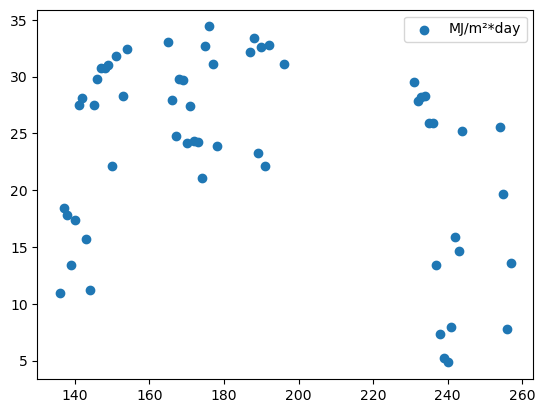

In [67]:
#Anzeigen den mega Joule von gutem DAtensatz
data = [("70B3D57ED005C6D1", dataD1, dataD1problem), ("70B3D57ED005C6D2", dataD2, dataD2problem)]
data = [("70B3D57ED005C6D0", dataD0, dataD0problem)]
megaJoule_per_day = []
days = []
for id,good,bad in data:
    for month, day in good:
        dayData = get_data(id, datetime(2023, month, day, 4), datetime(2023, month, day, 23))
        megaJoule_per_day.append(np.sum(lux_to_megajoule(dayData["light"]["time"],dayData["light"]["value"])))
        days.append(day_number_in_year(month,day))
plt.scatter(days,megaJoule_per_day,label="MJ/m²*day")
plt.legend()

Durchschnittliche Temperaturdifferenz im Zeitraum: 15.94 °C


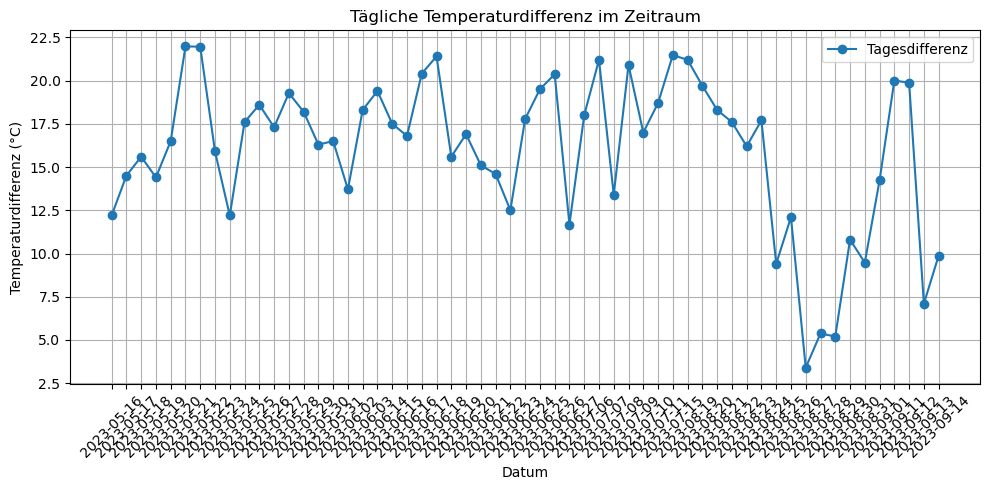

In [68]:
#Berechnung der durschnittstemperatur anahnde der guten Daten
id = '70B3D57ED005C6D0'

Temp_Diff_Day = []
Temp_Day_max = []
Temp_Day_min = []
dates = []

for month, day in dataD0:
    dayData = get_data(id, datetime(2023, month, day), datetime(2023, month, day)+timedelta(days=1))
    temp_values = dayData["temp"]["value"]
    Temp_Diff_Day.append(max(temp_values) - min(temp_values))
    Temp_Day_max.append(max(temp_values))
    Temp_Day_min.append(min(temp_values))
    dates.append(datetime(2023, month, day).strftime('%Y-%m-%d'))

avgTempDiffMonth = np.mean(Temp_Diff_Day)
print(f"Durchschnittliche Temperaturdifferenz im Zeitraum: {avgTempDiffMonth:.2f} °C")

plt.figure(figsize=(10, 5))
plt.plot(dates, Temp_Diff_Day, marker='o', label='Tagesdifferenz')
plt.xticks(rotation=45)
plt.xlabel('Datum')
plt.ylabel('Temperaturdifferenz (°C)')
plt.title('Tägliche Temperaturdifferenz im Zeitraum')
plt.grid()
plt.legend()
plt.tight_layout()

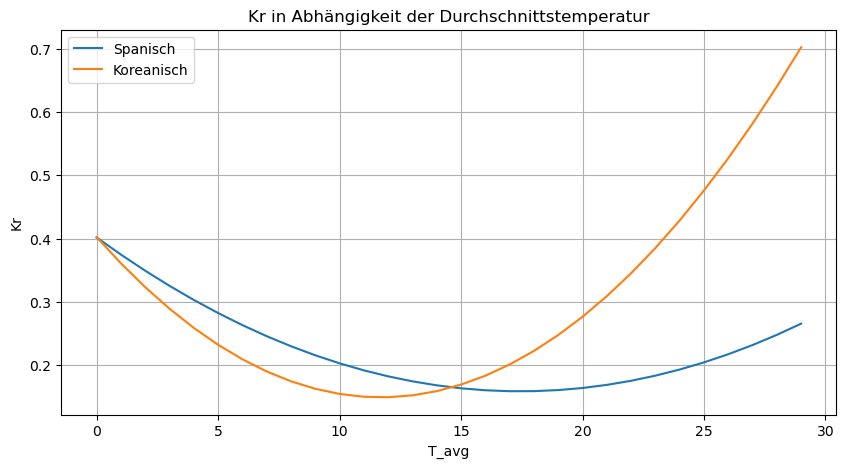

Kr Spanisch bei 15.943063475382113°C: 0.16023354742088958
Kr Koreanisch bei 15.943063475382113°C: 0.1822007065290714


In [69]:
# Berechnung Kr 
# kann auch angenommen werden im Bereich zwischen 0.16 und 0.19

def krKorean(T_avg):
    return (0.00185 * (T_avg)**2) - (0.0433 * (T_avg)) + 0.4023
def krSpanish(T_avg):
    return 0.0008 * (T_avg)**2 - 0.0279 * (T_avg) + 0.4017

Kr1 = []
Kr = []
for T_avarge in np.arange(0, 30, 1):
    Kr1.append(krSpanish(T_avarge)) #Spanisch
    Kr.append(krKorean(T_avarge)) #koreanisch
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 30, 1), Kr1, label="Spanisch")
plt.plot(np.arange(0, 30, 1), Kr, label="Koreanisch")
plt.legend()
plt.xlabel("T_avg")
plt.ylabel("Kr")
plt.title("Kr in Abhängigkeit der Durchschnittstemperatur")
plt.grid()
plt.show()

print(f"Kr Spanisch bei {avgTempDiffMonth}°C: {krSpanish(avgTempDiffMonth)}")
print(f"Kr Koreanisch bei {avgTempDiffMonth}°C: {krKorean(avgTempDiffMonth)}")

In [70]:
# Berechnung der maximal Einsatrhlung Rs0 nach FAO-56
import math
from datetime import datetime, date as date_cls

def rso_fao56(dayOfYear, lat_deg, elev_m, kwh=False):
    """
    Berechnet die Clear-Sky-Kurzwelleneinstrahlung R_so nach FAO-56.

    Parameter
    ---------
    dayOfYear : int
        DOY (1..366)
    lat_deg : float
        Geografischer Breitengrad in Grad (+N, -S).
    elev_m : float
        Höhe über Meeresspiegel in Metern.
    kwh : bool, optional
        Wenn True, Rückgabe in kWh/m²/Tag statt MJ/m²/Tag.

    Rückgabe
    --------
    float
        R_so als Tageswert (MJ/m²/Tag oder kWh/m²/Tag).
    """
    # 2) Konstanten und Winkel
    G_SC = 0.0820  # MJ m^-2 min^-1
    phi = math.radians(lat_deg)
    pi = math.pi

    # 3) Erdbahn und Geometrie (FAO-56)
    dr = 1.0 + 0.033 * math.cos(2.0 * pi * dayOfYear / 365.0)                          # relative Entfernung Erde-Sonne
    delta = 0.409 * math.sin(2.0 * pi * dayOfYear / 365.0 - 1.39)                      # Solardeklination
    cos_omega_s = -math.tan(phi) * math.tan(delta)                                   # Sonnenuntergangswinkel
    cos_omega_s = max(-1.0, min(1.0, cos_omega_s))                                   # numerische Klammer
    omega_s = math.acos(cos_omega_s)

    # 4) Extraterrestrische Strahlung Ra (MJ/m²/Tag)
    Ra = (24.0 * 60.0 / pi) * G_SC * dr * (
        omega_s * math.sin(phi) * math.sin(delta)
        + math.cos(phi) * math.cos(delta) * math.sin(omega_s)
    )

    # 5) Clear-Sky-Strahlung Rso (MJ/m²/Tag)
    Rso = (0.75 + 2.0e-5 * elev_m) * Ra

    # Optional: Ausgabe in kWh/m²/Tag
    if kwh:
        return Rso / 3.6
    return Rso


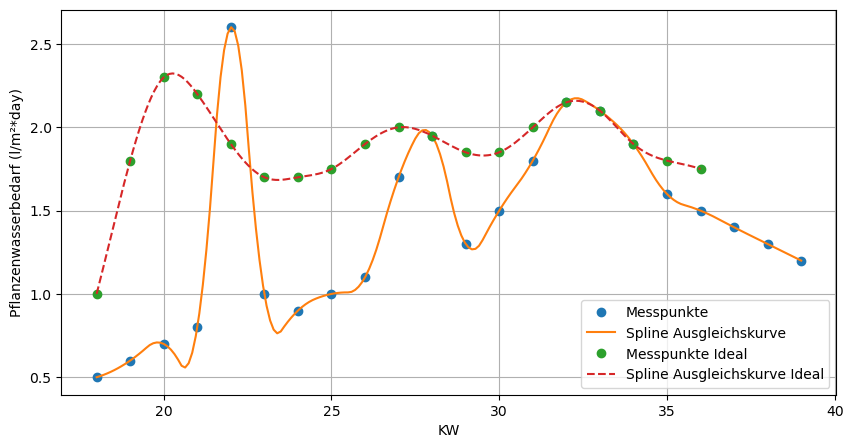

In [71]:
#Berechnung dynamischer Kc wert
from scipy.interpolate import UnivariateSpline
# Daten von https://kraege.de/wp-content/uploads/2024/11/www_Katalog_25_dt.pdf Seite 33 Frigo
KWIdeal = np.array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36])
WaterNeedIdeal = np.array([1,1.8,2.3,2.2,1.9,1.7,1.7,1.75,1.9,2,1.95,1.85,1.85,2,2.15,2.1,1.9,1.8,1.75])
KW = np.array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
WaterNeed = np.array([0.5,0.6,0.7,0.8,2.6,1,0.9,1,1.1,1.7,1.95,1.3,1.5,1.8,2.15,2.1,1.9,1.6,1.5,1.4,1.3,1.2])

# Werte für die Ausgleichskurve berechnen
KcSplineFit = UnivariateSpline(KW, WaterNeed, s=0, k=2)
KW_fit = np.linspace(KW.min(), KW.max(), 200)
Kc_fit = KcSplineFit(KW_fit)

KcSplineFitIdeal = UnivariateSpline(KWIdeal, WaterNeedIdeal, s=0)
KW_fitIdeal = np.linspace(KWIdeal.min(), KWIdeal.max(), 200)
Kc_fit_ideal = KcSplineFitIdeal(KW_fitIdeal)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(KW, WaterNeed, 'o', label='Messpunkte')
plt.plot(KW_fit, Kc_fit, '-', label='Spline Ausgleichskurve')
plt.plot(KWIdeal, WaterNeedIdeal, 'o', label='Messpunkte Ideal')
plt.plot(KW_fitIdeal, Kc_fit_ideal, '--', label='Spline Ausgleichskurve Ideal')
plt.xlabel('KW')
plt.ylabel('Pflanzenwasserbedarf (l/m²*day)')
plt.legend()
plt.grid()
plt.show()

In [72]:
from datetime import datetime

def calculate_evaporation_solar(date,Tdiff_daily,Kr,radiation):
    """
    Berechnet die Verdunstung basierend auf Solarstrahlung und Temperatur.
    Parameter:
    date : datetime
        Datum für die Berechnung.
    Tdiff_daily : float
        Tägliche Temperaturdifferenz in °C.
    radiation : float
        Solarstrahlung in MJ/m²/Tag.
    Kr : float
        Korrekturfaktor basierend auf der durchschnittlichen Tagestemperatur.

    Rückgabe:
    float array
        Verdunstung in mm/m²*Tag.
    """

    # Anpassung des Wasserverbrauches 4m² gemessen auf 1m² berechnung
    AreaCompensationFactor = 4  

    # constant parameters
    tau = 0.75
    hightOverSea = 596  # in m, can be set to the height of the location    
        
    # datum = datetime(2025, 7, 24)  # Beispiel: 24. Juli 2025
    DOY = date.timetuple().tm_yday

    KW_fraction = date.isocalendar().week + (date.isocalendar().weekday - 1) / 7 
    Kc = KcSplineFit(KW_fraction)  # Example value, can be adjusted based on the crop stage

    # Berechnung Rs
    Rs = Kr * (Tdiff_daily)** 0.5 * radiation
    RsmaxApprox = (0.75 + 2*10**-5 * hightOverSea) * radiation
    Rsmax = rso_fao56(DOY, 47.47337, hightOverSea, kwh=False)  # Example for Berlin

    # Berrechung Rs_green
    Rs_green = Rs * tau

    # ETo_green Annäherung
    if DOY <= 220:
        ETo_green = (0.288 + 0.0019* DOY) * Rs_green 
    elif DOY > 220:
        ETo_green = (1.3398 - 0.00288* DOY) * Rs_green 

    # Wasserverbrauch
    calculate_evaporation_solar = ETo_green * Kc * AreaCompensationFactor
    #correction factor for measuring 2m² ad calculating 1m²

    return calculate_evaporation_solar

#test evaporation

testData = get_data("70B3D57ED005C6D0", datetime(2023, 8, 23, 4), datetime(2023, 8, 23, 23))

Tmin = min(testData["temp"]["value"])
Tmax = max(testData["temp"]["value"])
T_avg = Tmax-Tmin
radiation = lux_to_megajoule(testData["light"]["time"], testData["light"]["value"])
print(f"Tmin: {Tmin}, Tmax: {Tmax}, T_avg: {T_avg}, radiation: {np.sum(radiation)}")

evaporation = calculate_evaporation_solar(datetime(2023, 8, 23), T_avg, krKorean(T_avg), radiation)
print(f"Evaporation on 2023-08-23: {np.sum(evaporation):.2f} mm/m²*day")


Tmin: 18.2, Tmax: 34.4, T_avg: 16.2, radiation: 25.87035707605882
Evaporation on 2023-08-23: 70.04 mm/m²*day


In [73]:
#TOOOO DOOOOOOs

#herausfinden wie viel wasser einen beregnungsperioode ist wie viel mm pro einmal bewässern.
#Episoden herausschneiden wie bei den realdaten
#Model so machen das wie wenn gemessen wird.
#D1 und D2 auch analysieren
#Dann irgendwann Training

Using kr: 0.16023354742088958


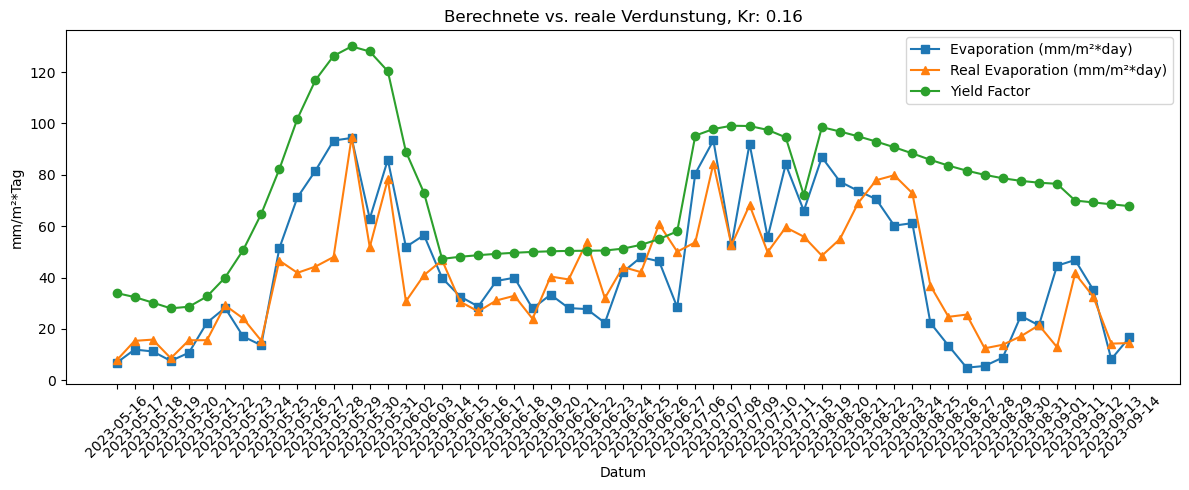

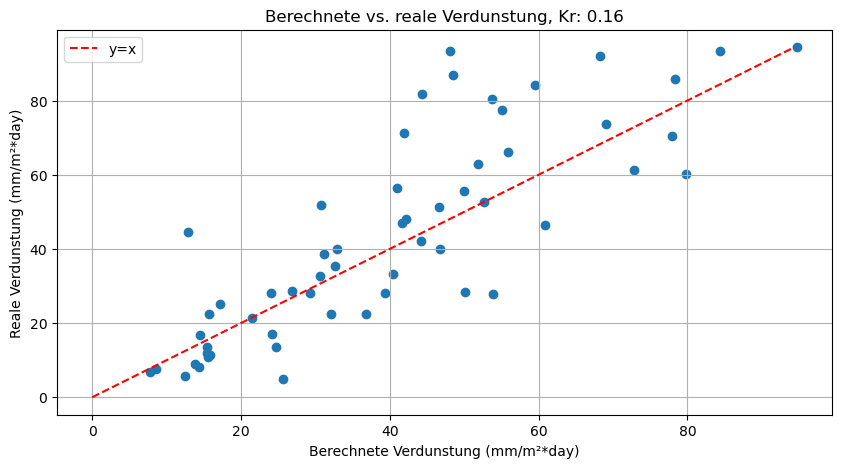

Korrelationskoeffizient: 0.83
Mittlerer Absoluter Fehler: 11.40 mm/m²*day
Mittlerer Fehler: -3.43 mm/m²*day
Mittlerer Realer Wasserverbrauch: 39.92 mm/m²*day
Mittlerer Berechneter Wasserverbrauch: 43.36 mm/m²*day
Mean Bias: 11.3982
Mean Absolute Error (Formel - Messung): 3.4308
Root Mean Square Error: 15.5910
Relative Error (%): 39.05
Ratio (Formel/Messung): 0.9209


In [74]:
id = '70B3D57ED005C6D0'
evo = []
realEvo = []
yieldFactor = []
dates = []
kr = krSpanish(avgTempDiffMonth) #koreanisch
print(f"Using kr: {kr}")

data = [("70B3D57ED005C6D0", dataD0, dataD0problem), ("70B3D57ED005C6D1", dataD1, dataD1problem), ("70B3D57ED005C6D2", dataD2, dataD2problem)]
data = data[0:1]

for id, good, bad in data:
    for month, day in good:
        dayData = get_data(id, datetime(2023, month, day), datetime(2023, month, day)+timedelta(days=1))
        Temp_Day_diff = max(dayData["temp"]["value"]) - min(dayData["temp"]["value"])
        radiation = lux_to_megajoule(dayData["light"]["time"],dayData["light"]["value"])
        calEvo = calculate_evaporation_solar(datetime(2023, month, day), Temp_Day_diff, kr, radiation)
        evo.append(np.sum(calEvo))
        realEvo.append(np.sum(dayData["drip"]["value"])*8-np.sum(dayData["drain"]["value"]))
        dates.append(datetime(2023, month, day).strftime('%Y-%m-%d'))
        KW_fraction = datetime(2023, month, day).isocalendar().week + (datetime(2023, month, day).isocalendar().weekday - 1) / 7
        yieldFactor.append(50*KcSplineFit(KW_fraction))
        # plt.figure(figsize=(10, 5))
        # plt.plot(dayData["light"]["time"], np.cumsum(calEvo), label="calculated Evaporation mm/m²*day")
        # plt.plot(dayData["light"]["time"], np.cumsum(dayData["drip"]["value"]), label="drip Irrigation ml")
        # plt.plot(dayData["light"]["time"], np.cumsum(dayData["drain"]["value"]), label="drain Drainage ml")
        # plt.plot(dayData["light"]["time"], np.cumsum(dayData["drip"]["value"])*7-np.cumsum(dayData["drain"]["value"]), label="real Evaporation mm/m²*day")
        # plt.legend()
        # plt.title(f"Evaporation on {month}-{day}, Kr: {round(kr,4)}")
        # plt.xlabel("Time (s)")
        # plt.show()
        # break
    
    plt.figure(figsize=(12,5))
    plt.plot(dates, evo, marker='s', label='Evaporation (mm/m²*day)')
    plt.plot(dates, realEvo, marker='^', label='Real Evaporation (mm/m²*day)')
    plt.plot(dates, yieldFactor, marker='o', label='Yield Factor')
    plt.xticks(rotation=45)
    plt.xlabel('Datum')
    plt.ylabel('mm/m²*Tag')
    plt.title('Berechnete vs. reale Verdunstung, Kr: '+str(round(kr,3)))
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(realEvo, evo)
    plt.plot([0, max(evo)], [0, max(evo)], 'r--', label='y=x')
    plt.xlabel('Berechnete Verdunstung (mm/m²*day)')
    plt.ylabel('Reale Verdunstung (mm/m²*day)')
    plt.title('Berechnete vs. reale Verdunstung, Kr: '+str(round(kr,3)))
    plt.legend()
    plt.grid()
    plt.show()
    print(f"Korrelationskoeffizient: {np.corrcoef(realEvo, evo)[0,1]:.2f}")
    print(f"Mittlerer Absoluter Fehler: {np.mean(np.abs(np.array(realEvo)-np.array(evo))):.2f} mm/m²*day")
    print(f"Mittlerer Fehler: {np.mean(np.array(realEvo)-np.array(evo)):.2f} mm/m²*day")
    print(f"Mittlerer Realer Wasserverbrauch: {np.mean(realEvo):.2f} mm/m²*day")
    print(f"Mittlerer Berechneter Wasserverbrauch: {np.mean(evo):.2f} mm/m²*day")

    # Zusätzliche Fehlermaße und Prints
    evapo_formel = np.array(evo)
    evapo_messuard = np.array(realEvo)

    mean_bias = np.mean(np.abs(evapo_formel - evapo_messuard))
    absolute_errors = np.mean(evapo_formel - evapo_messuard)
    root_mean_square_error = np.sqrt(np.mean((evapo_messuard - evapo_formel) ** 2))
    relative_error = (root_mean_square_error / np.mean(evapo_messuard)) * 100
    ratio = np.mean(evapo_messuard) / np.mean(evapo_formel)

    print(f"Mean Bias: {mean_bias:.4f}")
    print(f"Mean Absolute Error (Formel - Messung): {absolute_errors:.4f}")
    print(f"Root Mean Square Error: {root_mean_square_error:.4f}")
    print(f"Relative Error (%): {relative_error:.2f}")
    print(f"Ratio (Formel/Messung): {ratio:.4f}")

Korrekturfaktor für KW 20.5: 1.243


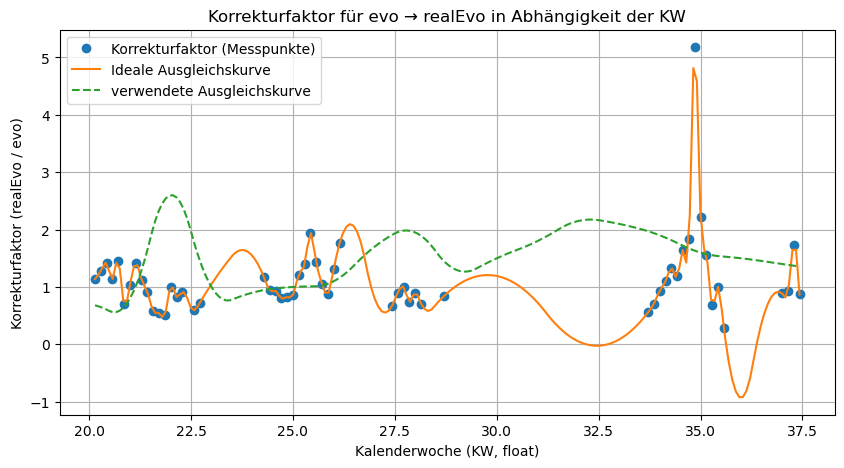

In [75]:
#theoretisch korrekte ausgleichskurve
import numpy as np
from scipy.interpolate import UnivariateSpline

data = [("70B3D57ED005C6D0", dataD0, dataD0problem), ("70B3D57ED005C6D1", dataD1, dataD1problem), ("70B3D57ED005C6D2", dataD2, dataD2problem)]
data = data[0:1]

dates = []
for id, good, bad in data:
    for month, day in good:
        dates.append(datetime(2023, month, day).strftime('%Y-%m-%d'))
        
# KW als float berechnen
kw_floats = []
for date_str in dates:
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    kw_float = dt.isocalendar().week + (dt.isocalendar().weekday - 1) / 7
    kw_floats.append(kw_float)
kw_floats = np.array(kw_floats)

# Korrekturfaktor berechnen
correction_factors = np.array(realEvo) / np.array(evo)

# Spline-Fit für die Korrekturfaktoren
correction_spline = UnivariateSpline(kw_floats, correction_factors, s=0, k=2)

# Beispiel: Korrekturfaktor für KW 20.5
kw_test = 20.5
print(f"Korrekturfaktor für KW {kw_test}: {correction_spline(kw_test):.3f}")

# Plot: Korrekturfaktor vs. KW
kw_fit = np.linspace(min(kw_floats), max(kw_floats), 200)
plt.figure(figsize=(10, 5))
plt.plot(kw_floats, correction_factors, 'o', label='Korrekturfaktor (Messpunkte)')
plt.plot(kw_fit, correction_spline(kw_fit), '-', label='Ideale Ausgleichskurve')
plt.plot(kw_fit, KcSplineFit(kw_fit), '--', label='verwendete Ausgleichskurve')
plt.xlabel('Kalenderwoche (KW, float)')
plt.ylabel('Korrekturfaktor (realEvo / evo)')
plt.legend()
plt.grid()
plt.title('Korrekturfaktor für evo → realEvo in Abhängigkeit der KW')
plt.show()

<>:69: SyntaxWarning: invalid escape sequence '\m'
<>:69: SyntaxWarning: invalid escape sequence '\s'
<>:69: SyntaxWarning: invalid escape sequence '\m'
<>:69: SyntaxWarning: invalid escape sequence '\s'
C:\Users\NilsWindows\AppData\Local\Temp\ipykernel_19176\999800201.py:69: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, p, 'k', linewidth=2, label=f'Normalverteilung\n$\mu$={mu:.2f}, $\sigma$={std:.2f}')
C:\Users\NilsWindows\AppData\Local\Temp\ipykernel_19176\999800201.py:69: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, p, 'k', linewidth=2, label=f'Normalverteilung\n$\mu$={mu:.2f}, $\sigma$={std:.2f}')
C:\Users\NilsWindows\AppData\Local\Temp\ipykernel_19176\999800201.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,27,30,31,32,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csvfilename, sep=';', decimal=',')


Average daily temperature difference from Tepfenhardt data: 12.50 °C


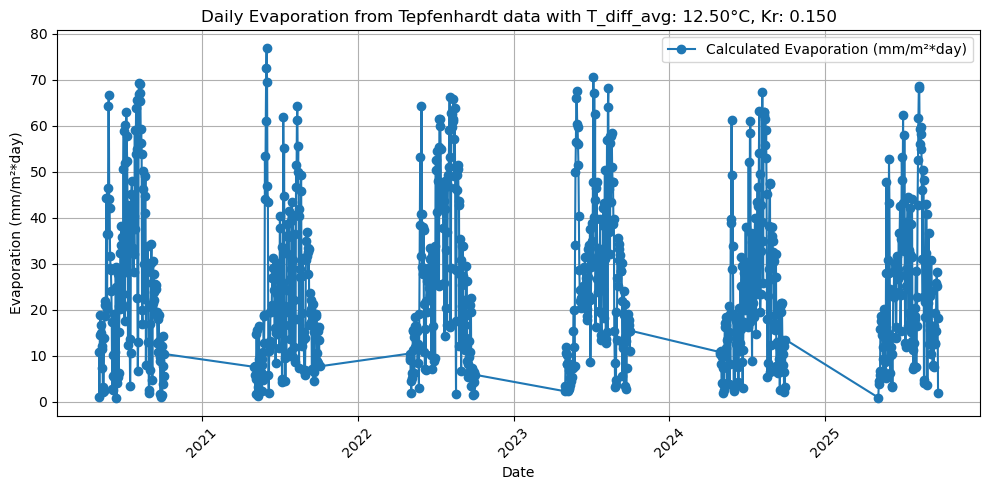

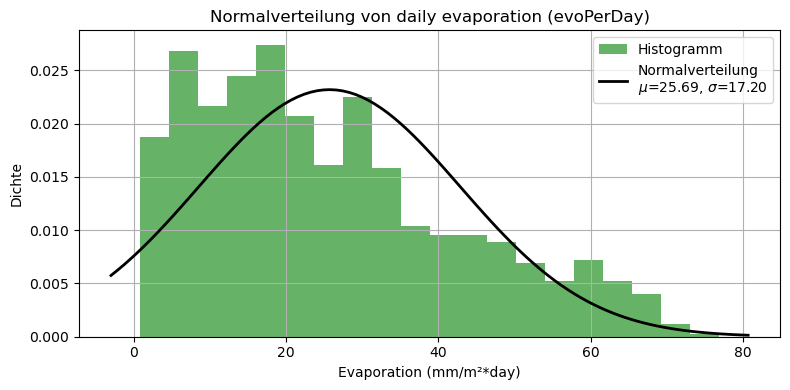

In [ ]:
csvfilename = "C:\\Users\\NilsWindows\\Desktop\\ResearchMasterRL\\data\\AgrarmeteoBaWü\\CSV\\Tepfenhardt.csv"
import pandas as pd

data = pd.read_csv(csvfilename, sep=';', decimal=',')
data = data.iloc[2:].reset_index(drop=True)  # Remove first 2 lines

tepfi = {}

tepfi['time'] = pd.to_datetime(data['TIMESTAMP'], format='%d.%m.%Y %H:%M')
tepfi['temp'] = data['AirTC_Avg'].astype(str).str.replace(',', '.').astype(float)
tepfi['humi'] = data['RH_Avg'].astype(str).str.replace(',', '.').astype(float)
tepfi['light'] = (data['SlrW_Avg'].astype(str).str.replace(',', '.').astype(float)*10*60)/1000000  # von W/m² zu Ws/m² (10min Mittelwert), dann zu MJ/m²

#NAN werte ersetzten
for key in tepfi: 
    tepfi[key] = tepfi[key].ffill(limit=1)
    if tepfi[key].isnull().any():
        raise ValueError(f"More than one NaN value in a row in {key} detected.")

# Trenne tepfi in einzelne Tage auf
tepfi_days = []
n = 0
for day, group in pd.DataFrame(tepfi).groupby(pd.to_datetime(tepfi['time']).dt.date):
    #lasse nur daten von Kalenderwoche 18 bis 39 zu
    if day.strftime('%W') >= '18' and day.strftime('%W') <= '39':
        #rohdaten der groupe überprüfen auf lücken
        tepfi_days.append({
            'date': day,
            'temp_diff_day': max(group['temp'].to_numpy()) - min(group['temp'].to_numpy()),
            'time': group['time'],
            'temp': group['temp'].to_numpy(),
            'light': group['light'].to_numpy(),
            'humi': group['humi'].to_numpy()
        })

#Erechnen der täglichen Temperartur Differenz
temp_avg_year = np.mean([day['temp_diff_day'] for day in tepfi_days])
print(f"Average daily temperature difference from Tepfenhardt data: {temp_avg_year:.2f} °C")

#Analysiere die Evaporationen
for day in tepfi_days:
    evaporation = calculate_evaporation_solar(
        day['date'],
        day['temp_diff_day'],
        krKorean(temp_avg_year),
        day['light']
    )
    day['evo'] = evaporation

plt.figure(figsize=(10, 5))
plt.plot([day['date'] for day in tepfi_days], [day['evo'].sum() for day in tepfi_days], marker='o', label='Calculated Evaporation (mm/m²*day)')
plt.title(f"Daily Evaporation from Tepfenhardt data with T_diff_avg: {temp_avg_year:.2f}°C, Kr: {krKorean(temp_avg_year):.3f}")
plt.xlabel("Date")
plt.ylabel("Evaporation (mm/m²*day)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot Normalverteilung von evoPerDay
import scipy.stats as stats
plt.figure(figsize=(8, 4))
n, bins, patches = plt.hist([day['evo'].sum() for day in tepfi_days], bins=20, density=True, alpha=0.6, color='g', label='Histogramm')
mu, std = stats.norm.fit([day['evo'].sum() for day in tepfi_days])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Normalverteilung\n$\mu$={mu:.2f}, $\sigma$={std:.2f}')
plt.xlabel("Evaporation (mm/m²*day)")
plt.ylabel("Dichte")
plt.title("Normalverteilung von daily evaporation (evoPerDay)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

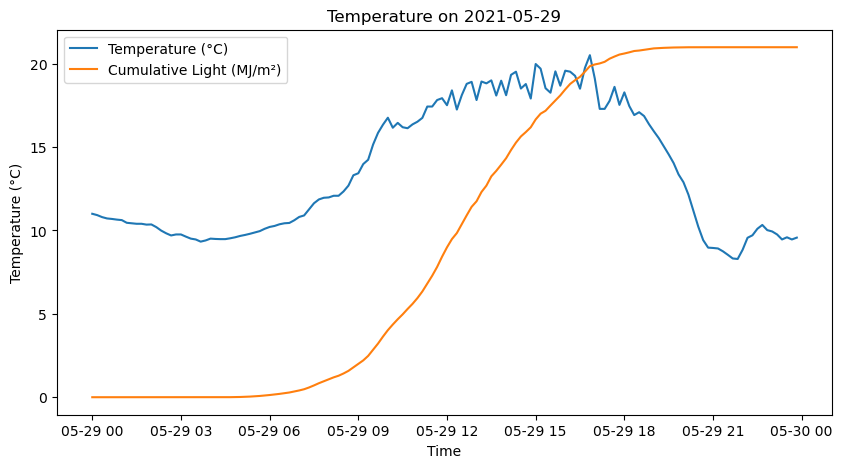

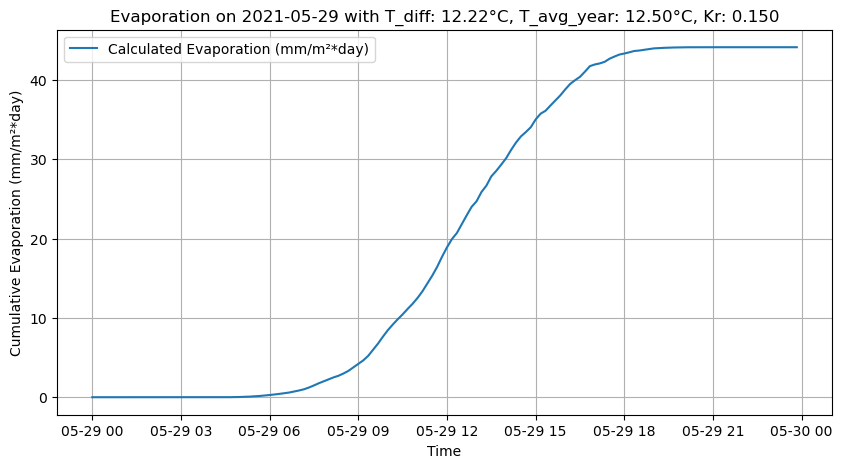

In [77]:
#Analysieren von einzlnem Tag
a= tepfi_days[180]
#plotte einen tag
plt.figure(figsize=(10, 5))
plt.plot(a['time'], a['temp'], label='Temperature (°C)')
plt.plot(a['time'], a['light'].cumsum(), label='Cumulative Light (MJ/m²)')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title(f"Temperature on {a['date']}")

evaporation = calculate_evaporation_solar(
    a['date'],
    a['temp_diff_day'],
    krKorean(temp_avg_year),
    a['light']
)
plt.figure(figsize=(10, 5))
plt.plot(a['time'], evaporation.cumsum(), label='Calculated Evaporation (mm/m²*day)')
plt.title(f"Evaporation on {a['date']} with T_diff: {a['temp_diff_day']:.2f}°C, T_avg_year: {temp_avg_year:.2f}°C, Kr: {krKorean(temp_avg_year):.3f}")
plt.xlabel("Time")
plt.ylabel("Cumulative Evaporation (mm/m²*day)")
plt.legend()
plt.grid()
plt.show()

In [141]:
import os
import csv

def seconds_since_midnight(timestamps):
    """Gibt die Tageszeit in Sekunden (0-86400) für ein datetime-Objekt zurück."""
    midnight = timestamps.dt.normalize()
    return (timestamps - midnight).dt.total_seconds()

def make_drain_curve(total_drain, samples):
    # nach 10 min 70%
    # nach 20 min 90%
    # nach 30 min 100%
    # erstellt eine Drainkurve in der Länge der Episoden samples
    values = [0, 0.7*total_drain, 0.9*total_drain]
    # Schneide oder fülle auf die gewünschte Länge
    if samples <= len(values):
        return values[:samples]
    else:
        values += [total_drain] * (samples - len(values))
        return values

def split_day_by_evo(day, threshold=2.0):
    #episode auschneiden länge = 5l(ideal)+ Überschuss Drain in l([-0,75,+2]l)
    #dann wert von Überschusss (+-2l) durch ausgleichskurve in Drainkurve umwandeln
    # nach 10 min 70%
    # nach 20 min 90%
    # nach 30 min 100%
    """
    Teilt jeden Tag in tepfi_days in Episoden, sodass jede Episode ca. threshold mm (z.B. 2mm) kumulierte Verdunstung enthält.
    Jede Episode enthält die kompletten Wertearrays (temp, humi, light, etc.) für den jeweiligen Abschnitt.
    Rückgabe: Liste von Episoden, jede Episode ist ein Dict mit den Feldern wie ein Tag, aber nur für den Episodenbereich.
    """
    episodes = []
    evo = np.asarray(day['evo'])
    cumsum = np.cumsum(evo)
    start_idx = 0
    last_cum = cumsum[0] if len(cumsum) > 0 else 0
    drain = np.random.uniform(-0.75, 2.0)
    threshold_total = threshold + drain  # füge zufälligen Überschuss hinzu
    if 'date' in day:
        del day['date']
    if 'temp_diff_day' in day:
        del day['temp_diff_day']
    for i in range(1, len(evo)):
        if cumsum[i] - last_cum >= threshold_total:
            epi = {}
            for key in day:
                epi[key] = day[key][start_idx:i]
            epi['drain'] = make_drain_curve(threshold_total, i - start_idx)
            episodes.append(epi)
            start_idx = i
            last_cum = cumsum[i]
            new_drain = np.random.uniform(-0.75, 2.0)
            threshold_total = threshold + new_drain  # neuer zufälliger Überschuss
    # letzte Episode bis zum Ende
    if start_idx < len(evo):
        epi = {}
        for key in day:
            epi[key] = day[key][start_idx:]
        episodes.append(epi)
    return episodes

#save Episodes from data
def save_Episode(baseFolder, month, day, episodes):
    if not os.path.exists(baseFolder):
        os.makedirs(baseFolder)

    for i, epi in enumerate(episodes):
        fileName = os.path.join(baseFolder, f"{month}-{day}-Epi{i}.csv")
        with open(fileName, "w", newline="") as file:
            writer = csv.writer(file)
            for j in range(len(epi['time'])):
                observation = [
                    epi['doy'],
                    epi['abstime'][j],
                    epi['time'][j],
                    epi['temp'][j],
                    epi['humi'][j],
                    epi['light'][j],
                    epi['drain'][j],
                    epi['timeToIrri'][j]
                ]
                writer.writerow(observation)

episodenAll = []
savePath = "2. basic simuliert mit 7090100 drain"
for day in tepfi_days:
    epiDay = split_day_by_evo(day, threshold=5.0)
    episodenRaw = epiDay[1:-1]  # ggf. [1:-1] für Episodenfilter
    episoden = []
    for epiRaw in episodenRaw:
        episode = {}
        episode['doy'] = pd.Timestamp(epiRaw['time'].iloc[0]).dayofyear / 280  # max 280 Tage (KW39=273doy)
        episode['abstime'] = np.array(seconds_since_midnight(epiRaw['time'])) / (24*3600)
        episode['time'] = np.array((epiRaw['time'] - epiRaw['time'].iloc[0]).dt.total_seconds()) / (60 * 300) # in min und max 300 min Episode
        episode['temp'] = np.array(epiRaw['temp']) / 25 # 25°C max
        episode['humi'] = np.array(epiRaw['humi']) / 100 # 100% max
        episode['light'] = epiRaw['light'].cumsum() / 20 # 20 MJ/testfläche max
        episode['timeToIrri'] = np.array((epiRaw['time'].iloc[-1] - epiRaw['time']).dt.total_seconds()) / 60 # in min
        episode['drain'] = np.array(epiRaw['drain']) / 7 # 7l max
        episoden.append(episode)
    episodenAll.append(episoden)
    month = pd.Timestamp(day['time'].iloc[0]).month
    daynum = pd.Timestamp(day['time'].iloc[0]).day
    save_Episode(savePath, str(month), str(daynum), episoden)